# Clustering: Spectral

## References

https://www.kaggle.com/datasets/arjunbhasin2013/ccdata

## Import Python Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_blobs
from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import SpectralClustering, KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.utils import resample

## Global Variables

In [2]:
# random state 
random_state = 4781
# random_state = 7644

# colors
c_scale = 256
c1 = (1, 1, 1) # grey
c2 = (1, 0, 0) # red
c3 = (181/c_scale, 204/c_scale, 6/c_scale) # yellow
c4 = (6/c_scale, 122/c_scale, 204/c_scale) # blue
c5 = (0, 0, 0) # black
c6 = ["#fbfce6", "#a2daf2", "#ffc7c7"]
c7 = [(0, 0, 1), (0, 1 ,0), (1, 0, 0)]

## Import Dataset

In [3]:
# Source: https://www.kaggle.com/datasets/arjunbhasin2013/ccdata

# Dataset Column Overview: 
# ------------------------------------------------------------------------------

# X01: CUST_ID : Identification of Credit Card holder (Categorical)
# X02: BALANCE : Balance amount left in their account to make purchases (
# X03: BALANCE_FREQUENCY : How frequently the Balance is updated, score between 0 and 1 (1 = frequently updated, 0 = not frequently updated)
# X04: PURCHASES : Amount of purchases made from account
# X05: ONEOFF_PURCHASES : Maximum purchase amount done in one-go
# X06: INSTALLMENTS_PURCHASES : Amount of purchase done in installment
# X07: CASH_ADVANCE : Cash in advance given by the user
# X08: PURCHASES_FREQUENCY : How frequently the Purchases are being made, score between 0 and 1 (1 = frequently purchased, 0 = not frequently purchased)
# X09: ONEOFFPURCHASESFREQUENCY : How frequently Purchases are happening in one-go (1 = frequently purchased, 0 = not frequently purchased)
# X10: PURCHASESINSTALLMENTSFREQUENCY : How frequently purchases in installments are being done (1 = frequently done, 0 = not frequently done)
# X11: CASHADVANCEFREQUENCY : How frequently the cash in advance being paid
# X12: CASHADVANCETRX : Number of Transactions made with "Cash in Advanced"
# X13: PURCHASES_TRX : Numbe of purchase transactions made
# X14: CREDIT_LIMIT : Limit of Credit Card for user
# X15: PAYMENTS : Amount of Payment done by user
# X16: MINIMUM_PAYMENTS : Minimum amount of payments made by user
# X17: PRCFULLPAYMENT : Percent of full payment paid by user
# X18: TENURE : Tenure of credit card service for user

In [4]:
# load dataset from github
filepath1 = 'https://raw.githubusercontent.com/notfakearcher/julian/main/02_data/credit_card_customers.csv'
df0 = pd.read_csv(filepath1, header = 0)
df0['y'] = 'Missing'
df0.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,y
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12,Missing
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12,Missing
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12,Missing
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12,Missing
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12,Missing


In [5]:
# identify X_cols and y_col
all_cols = df0.columns.values.copy()
y_col = 'y'
cond1 = all_cols != y_col
X_cols = all_cols[cond1]

In [6]:
# standardize column names
df1 = df0.copy()
zeros = len(str(len(X_cols)))
new_all_cols = all_cols
temp = (np.arange(0, len(X_cols)) + 1).astype('str')

new_y_col = 'y'
new_X_cols = ['X' + i.zfill(zeros) for i in temp]

new_all_cols[cond1] = new_X_cols
new_all_cols[~cond1] = new_y_col

df1.columns = new_all_cols

df1.y = df1.y.astype('str')

df1.head()


,X01,X02,X03,X04,X05,X06,X07,X08,X09,X10,X11,X12,X13,X14,X15,X16,X17,X18,y
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12,Missing
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12,Missing
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12,Missing
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12,Missing
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12,Missing


In [7]:
# check data structure
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 19 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X01     8950 non-null   object 
 1   X02     8950 non-null   float64
 2   X03     8950 non-null   float64
 3   X04     8950 non-null   float64
 4   X05     8950 non-null   float64
 5   X06     8950 non-null   float64
 6   X07     8950 non-null   float64
 7   X08     8950 non-null   float64
 8   X09     8950 non-null   float64
 9   X10     8950 non-null   float64
 10  X11     8950 non-null   float64
 11  X12     8950 non-null   int64  
 12  X13     8950 non-null   int64  
 13  X14     8949 non-null   float64
 14  X15     8950 non-null   float64
 15  X16     8637 non-null   float64
 16  X17     8950 non-null   float64
 17  X18     8950 non-null   int64  
 18  y       8950 non-null   object 
dtypes: float64(14), int64(3), object(2)
memory usage: 1.3+ MB


In [8]:
# describe data
df1.describe()

,X02,X03,X04,X05,X06,X07,X08,X09,X10,X11,X12,X13,X14,X15,X16,X17,X18
count,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8949.000000,8950.000000,8637.000000,8950.000000,8950.000000
mean,1564.474828,0.877271,1003.204834,592.437371,411.067645,978.871112,0.490351,0.202458,0.364437,0.135144,3.248827,14.709832,4494.449450,1733.143852,864.206542,0.153715,11.517318
std,2081.531879,0.236904,2136.634782,1659.887917,904.338115,2097.163877,0.401371,0.298336,0.397448,0.200121,6.824647,24.857649,3638.815725,2895.063757,2372.446607,0.292499,1.338331
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.000000,0.000000,0.019163,0.000000,6.000000
25%,128.281915,0.888889,39.635000,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,1.000000,1600.000000,383.276166,169.123707,0.000000,12.000000
50%,873.385231,1.000000,361.280000,38.000000,89.000000,0.000000,0.500000,0.083333,0.166667,0.000000,0.000000,7.000000,3000.000000,856.901546,312.343947,0.000000,12.000000
75%,2054.140036,1.000000,1110.130000,577.405000,468.637500,1113.821139,0.916667,0.300000,0.750000,0.222222,4.000000,17.000000,6500.000000,1901.134317,825.485459,0.142857,12.000000
max,19043.138560,1.000000,49039.570000,40761.250000,22500.000000,47137.211760,1.000000,1.000000,1.000000,1.500000,123.000000,358.000000,30000.000000,50721.483360,76406.207520,1.000000,12.000000


In [9]:
# check missing values
df1.isna().sum()

X01      0
X02      0
X03      0
X04      0
X05      0
X06      0
X07      0
X08      0
X09      0
X10      0
X11      0
X12      0
X13      0
X14      1
X15      0
X16    313
X17      0
X18      0
y        0
dtype: int64

## Data Cleaning and Transformation

In [10]:
# drop useless columns
drop_id = ['X01']
df1 = df1.drop(columns = drop_id, errors = 'ignore')

df1.head()

,X02,X03,X04,X05,X06,X07,X08,X09,X10,X11,X12,X13,X14,X15,X16,X17,X18,y
0,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12,Missing
1,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12,Missing
2,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12,Missing
3,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12,Missing
4,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12,Missing


In [11]:
# response column
y_col = new_y_col
y_col

'y'

In [12]:
# predictor columns
cond1 = df1.columns != y_col
X_cols = df1.columns[cond1]
X_cols

Index(['X02', 'X03', 'X04', 'X05', 'X06', 'X07', 'X08', 'X09', 'X10', 'X11',
       'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18'],
      dtype='object')

In [13]:
# get unique y_labels
y_labels = np.sort(df1[y_col].unique())
y_labels = {y_labels[i]: i for i in range(len(y_labels))}
# y_labels = {i:y_labels[i] for i in range(len(y_labels))}
y_labels

{'Missing': 0}

In [14]:
# rename y_labels
df1[y_col] = df1[y_col].replace(y_labels)
df1.head()

,X02,X03,X04,X05,X06,X07,X08,X09,X10,X11,X12,X13,X14,X15,X16,X17,X18,y
0,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12,0
1,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12,0
2,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12,0
3,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12,0
4,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12,0


In [15]:
# remove rows with missing valus
for col in df1.columns:
  cond1 = ~((df1[col].isna()))
  df1 = df1.loc[cond1,:]
  
df1.isna().sum()

X02    0
X03    0
X04    0
X05    0
X06    0
X07    0
X08    0
X09    0
X10    0
X11    0
X12    0
X13    0
X14    0
X15    0
X16    0
X17    0
X18    0
y      0
dtype: int64

In [16]:
# # check label distribution
# temp_labels = list(y_labels.values())
# cond_list = []
# count_list = []
# for i in np.arange(len(temp_labels)):
#   # condition for rows matching response label
#   # print(i)
#   x = temp_labels[i]
#   temp_cond = list(df1[y_col] == x)
#   cond_list.append(temp_cond)
#   # print(cond_list)
#   # get total label count
#   temp_n = np.sum(cond_list[i])
#   # print(temp_n)
#   count_list.append(temp_n)
  
# # max label count
# n_max = np.max(count_list)
# # index where max value occurs
# i_max = np.where(count_list == n_max)[0][0]
# # index where max value does not occurs
# i_notmax = np.where(count_list != n_max)[0]

# print(temp_labels)
# print(count_list)
# print(n_max)
# print(i_max)
# print(i_notmax)

In [17]:
# # upsample minority labels
# df_upsample_list = []
# for i in i_notmax:
#   # print(i)
#   # get dataframe rows where label exsists
#   cond = cond_list[i]
#   # print(cond)
#   df_temp = df1.iloc[cond,:]
#   # print(df_temp.info())
  
#   # determine amount to upsample 
#   n_diff = n_max - count_list[i]
#   # print(n_diff)
  
#   # generate upsample dataframe 
#   df_upsample_temp = resample(
#     df_temp,
#     replace = True,
#     n_samples = n_diff,
#     random_state = random_state
#   )
#   df_upsample_list.append(df_upsample_temp)

# # put all dataframes in df_upsample_list into one
# df_upsample_list = pd.concat(df_upsample_list, ignore_index = True)

# # update df1 with upsampled dataframe
# df1 = pd.concat([df1, df_upsample_list], ignore_index = True)
# df1.info()

In [18]:
# # encode categorical values to numerical values
# le = LabelEncoder()

# categorical_cols = df1[X_cols].select_dtypes("object").columns
# # df1[categorical_cols] = df1[categorical_cols].apply(le.fit_transform)

# df1.head()

In [19]:
# update df1
X = df1[X_cols]
y = df1[y_col]
df1 = pd.concat([X, y], axis = 1)
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8636 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X02     8636 non-null   float64
 1   X03     8636 non-null   float64
 2   X04     8636 non-null   float64
 3   X05     8636 non-null   float64
 4   X06     8636 non-null   float64
 5   X07     8636 non-null   float64
 6   X08     8636 non-null   float64
 7   X09     8636 non-null   float64
 8   X10     8636 non-null   float64
 9   X11     8636 non-null   float64
 10  X12     8636 non-null   int64  
 11  X13     8636 non-null   int64  
 12  X14     8636 non-null   float64
 13  X15     8636 non-null   float64
 14  X16     8636 non-null   float64
 15  X17     8636 non-null   float64
 16  X18     8636 non-null   int64  
 17  y       8636 non-null   int64  
dtypes: float64(14), int64(4)
memory usage: 1.3 MB


In [20]:
# normalize all X_cols
df2 = df1.copy()
norm = StandardScaler()
# norm = MinMaxScaler()
# norm = RobustScaler()
df2[X_cols] = norm.fit_transform(df2[X_cols])

df2.head()

,X02,X03,X04,X05,X06,X07,X08,X09,X10,X11,X12,X13,X14,X15,X16,X17,X18,y
0,-0.744625,-0.370047,-0.429184,-0.359160,-0.354826,-0.468655,-0.820769,-0.686280,-0.717179,-0.681953,-0.479437,-0.517623,-0.962575,-0.543942,-0.305508,-0.537727,0.355181,0
1,0.764152,0.067679,-0.473208,-0.359160,-0.458839,2.568556,-1.236139,-0.686280,-0.926522,0.557022,0.099258,-0.597054,0.677204,0.796852,0.087689,0.212380,0.355181,0
2,0.426602,0.505405,-0.116413,0.099909,-0.458839,-0.468655,1.256077,2.646651,-0.926522,-0.681953,-0.479437,-0.120467,0.813852,-0.399503,-0.099906,-0.537727,0.355181,0
4,-0.373910,0.505405,-0.465825,-0.349660,-0.458839,-0.468655,-1.028455,-0.408536,-0.926522,-0.681953,-0.479437,-0.557339,-0.907916,-0.380165,-0.261131,-0.537727,0.355181,0
5,0.099551,0.505405,0.142062,-0.359160,0.994815,-0.468655,0.425339,-0.686280,0.538882,-0.681953,-0.479437,-0.279329,-0.743938,-0.132119,0.650363,-0.537727,0.355181,0


In [21]:
# # remove outliers from each column
# for X in X_cols:
#   cond1 = ~((df2[X] >= 3) | (df2[X] <= -3))
#   df2 = df2.loc[cond1,:]
  
# df2.info()

## Visualize Dataset

In [22]:
# figure setup
fig_cols = 5
fig_rows = np.ceil(len(X_cols)/fig_cols).astype('int')
y_max = np.round(df2[X_cols].max().max(), 0)
y_min = np.round(df2[X_cols].min().min(), 0)
n_levels = df2.y.unique().size
palette1 = [c1 for i in range(n_levels)]
palette2 = [c3, c4]
figsize = (30, 15)

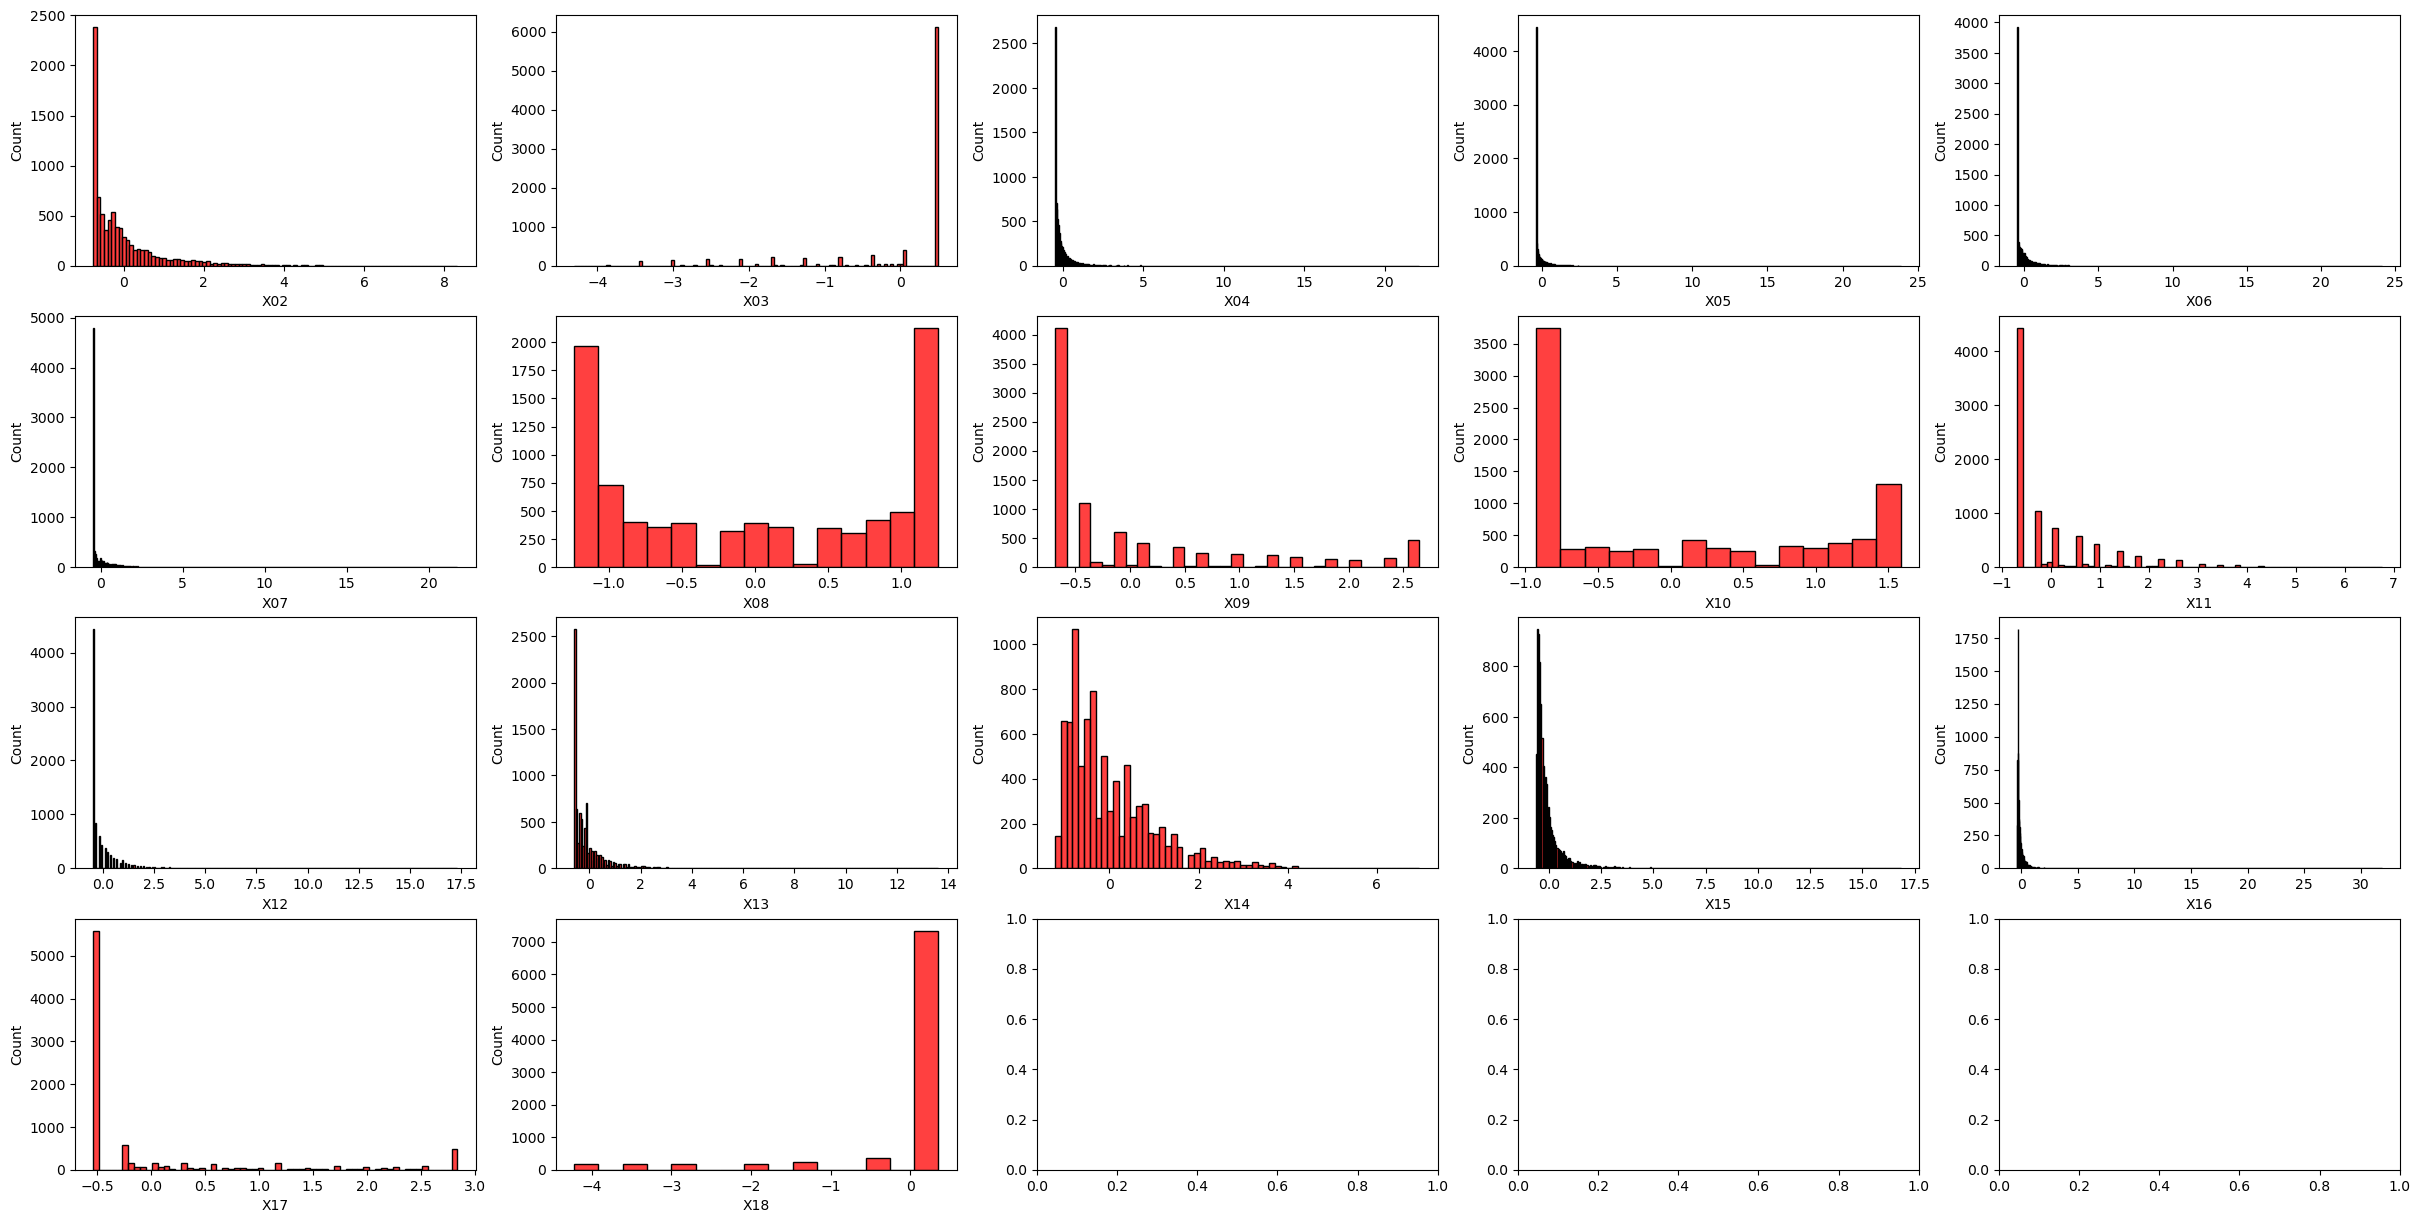

In [23]:
# subplot of y vs each X (stripplot + violinplot + boxenplot)
f1, axes = plt.subplots(fig_rows, fig_cols, figsize = figsize)
itr = 0
for x in X_cols:
  row = np.floor(itr/fig_cols) 
  row = row.astype('int')
  col = np.mod(itr, fig_cols)
  col = col.astype('int') 
  # print(row)
  # print(col)
  # p1 = sns.violinplot(ax = axes[row, col], data = df2, x = y_col, y = x, hue = y_col, palette = palette1)
  # p2 = sns.boxenplot(ax = axes[row, col], data = df2, x = y_col, y = x, hue = y_col, palette = palette1)
  # p3 = sns.scatterplot(ax = axes[row, col], data = df2, x = y_col, y = x, color = c2, size = 1)
  # p4 = sns.pointplot(ax = axes[row, col], data = df2, x = y_col, y = x, color = c5, linewidth = 1)
  p5 = sns.histplot(ax = axes[row, col], data = df2, x = x, color = c2, linewidth = 1)
  axes[row, col].legend_ = None
  # axes[row, col].set_ylim(y_min, y_max)
  itr = itr + 1

## Train and Test ML Model

In [24]:
# seperate data into X and y
X = df2[X_cols]
y = np.ravel(df2[y_col])

In [25]:
# split data into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, 
  stratify = y, shuffle = True, 
  train_size = 0.8, random_state = random_state
)

In [26]:
# get principal components
pca = PCA(n_components = 2)

In [27]:
# fit principal components to training data
temp = pca.fit(X_train, y_train)

In [28]:
# pca explained variance ration
var_ratio = pca.explained_variance_ratio_
var_ratio.sum()

0.47243630306558754

In [29]:
# transform data based on principal components
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

In [30]:
# set list of k values to explore
k_values = np.arange(1, 10, 1)
k_values

array([1, 2, 3, 4, 5, 6, 7, 8, 9])

In [126]:
# X = X_train
# y = y_train

# X, y = make_blobs(
#     n_samples=500,
#     n_features=2,
#     centers=4,
#     cluster_std=1,
#     center_box=(-10.0, 10.0),
#     shuffle=True,
#     random_state=1,
# )  # For reproducibility

In [141]:
# function for plotting clusters
def jra_plot_clusters(X, k_values, affinity = 'nearest_neighbors'):
  # set list of k values to explore
  for k in k_values:
    # plot subplots
    fig, axes = plt.subplots(1, 2, figsize = (18, 7))
    # title for sup-plot
    plt.suptitle("Evaluation Plots for k = $%d$" %k)
    # initialize clustering model
    clustering_model = SpectralClustering(n_clusters = k, affinity = affinity, random_state = random_state)
    # fit model and predict labels
    y_hat = clustering_model.fit_predict(X)
    # get average silhouette score
    silhouette_avg = silhouette_score(X, labels = y_hat)
    # silhoutte score for each sample
    silhouette_values = silhouette_samples(X, labels = y_hat)
    # plot (left): silhoutte plot
    plt.subplot(121)
    
    # initialize plot parameters
    y_min = 0
    y_max = len(X)
    x_min = 0
    x_max = 1
    plt.xlim([x_min - 0.1, x_max])
    plt.ylim([y_min, y_max])
    
    for i in range(k):
      # aggregate silhoutte value for given cluster, c
      cluster_silhouette_values = silhouette_values[y_hat == i]
      # sort silhoutte values
      cluster_silhouette_values.sort()
      # cluster size
      cluster_size = cluster_silhouette_values.shape[0]
      # define fill region for silhoutte
      silhoutte_fill = cm.nipy_spectral(float(i) / k)
      # set max y-value
      y_max = y_min + cluster_size
      # set y-values vector
      y_values = np.arange(y_min, y_max)
      # plot silhouttle
      plt.fill_betweenx(
        y_values,
        0,
        cluster_silhouette_values,
        facecolor = silhoutte_fill,
        edgecolor = silhoutte_fill,
        alpha = 0.7
      )
      # add cluster number
      plt.text(x = x_min, y = y_min + 0.5 * cluster_size, s = str(i + 1),
              fontsize = 12, fontweight = 'bold'
        )
      # update y_min values to separate silhouttes
      y_min = y_max
      # y_min = y_max + (0.05 * y_max)
    
    
    # clean up plot
    plt.axvline(x = silhouette_avg, color="red", linestyle="--")
    plt.text(x = silhouette_avg, y = 0.1*y_max, s = str(silhouette_avg.round(4)), 
            rotation = 0, fontsize = 12
            )
    plt.xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.yticks([])
    plt.xlabel('Silhoutte Score')
    plt.ylabel('Cluster')
    plt.title('Silhoutte Plot:\n Training Labels vs PCA Components 1 and 2')
    
    
    # plot (right): cluster plot
    plt.subplot(122)
    
    # initialize plot paramaters
    X1_values = X[:, 0]
    X2_values = X[:, 1]
    X1_min = X1_values.min() - 1
    X2_min = X2_values.min() - 1
    X1_max = X1_values.max() + 1
    X2_max = X2_values.max() + 1
    
    # generate point color map
    colors_point = cm.nipy_spectral(y_hat.astype(float) / k)
    
    # plot clusters
    plt.scatter(x = X1_values, y = X2_values, 
      color = colors_point, 
      edgecolor = "k",
      marker = ".", 
      s = 35, 
      alpha = 1,
      lw = 0
    )

    # clean up plot
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title('Cluster Plot:\n Training Labels vs PCA Components 1 and 2')
    plt.xlim(X1_min, X1_max)
    plt.ylim(X2_min, X2_max)

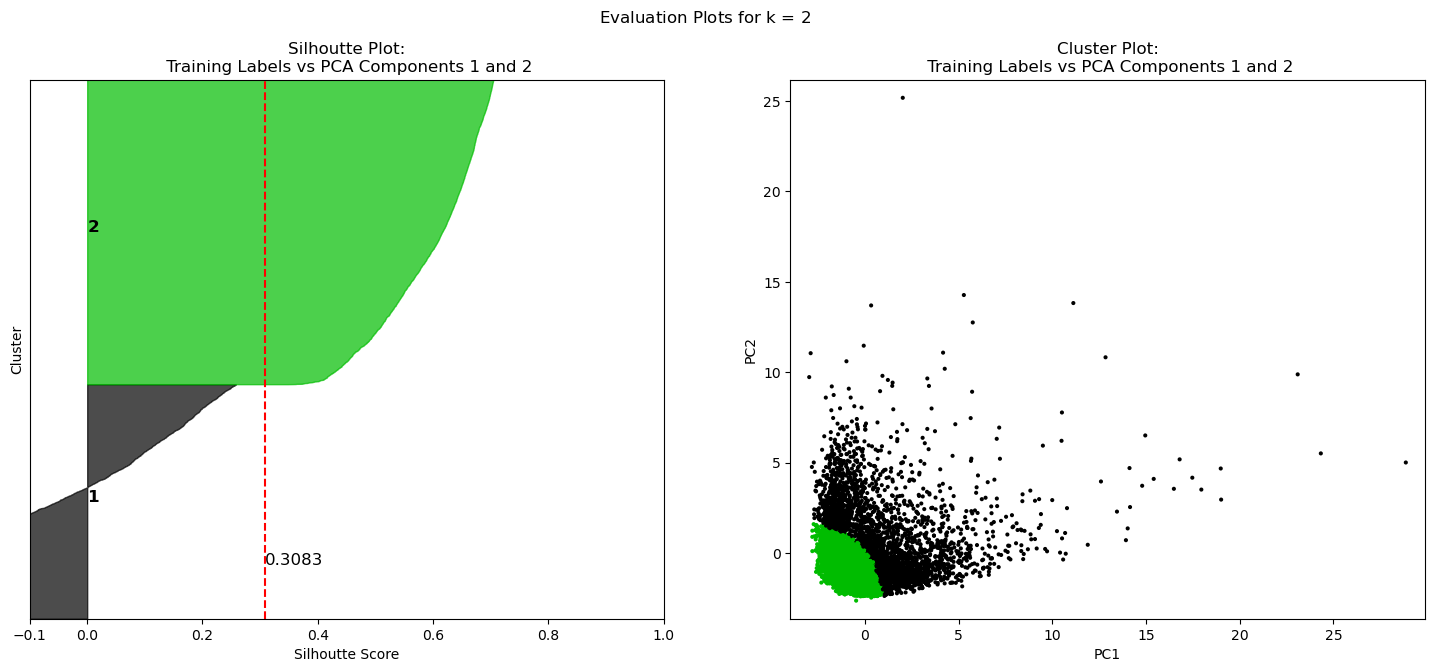

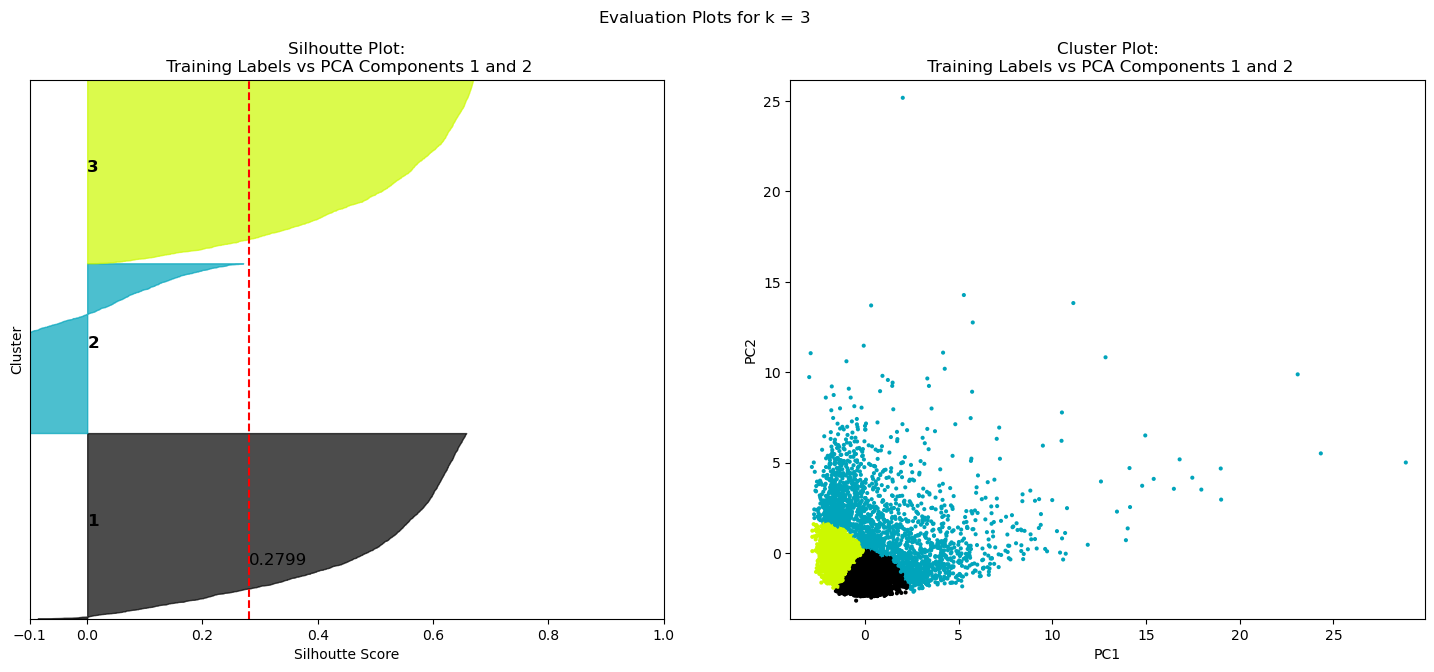

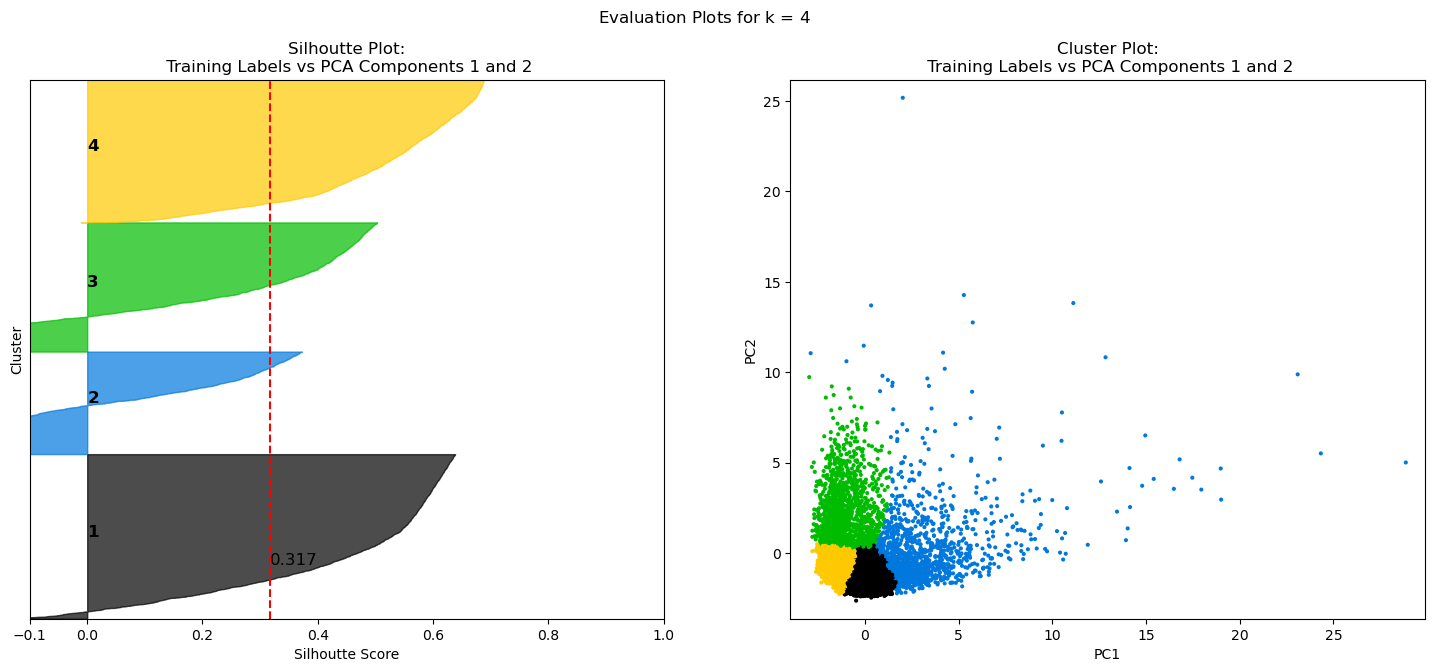

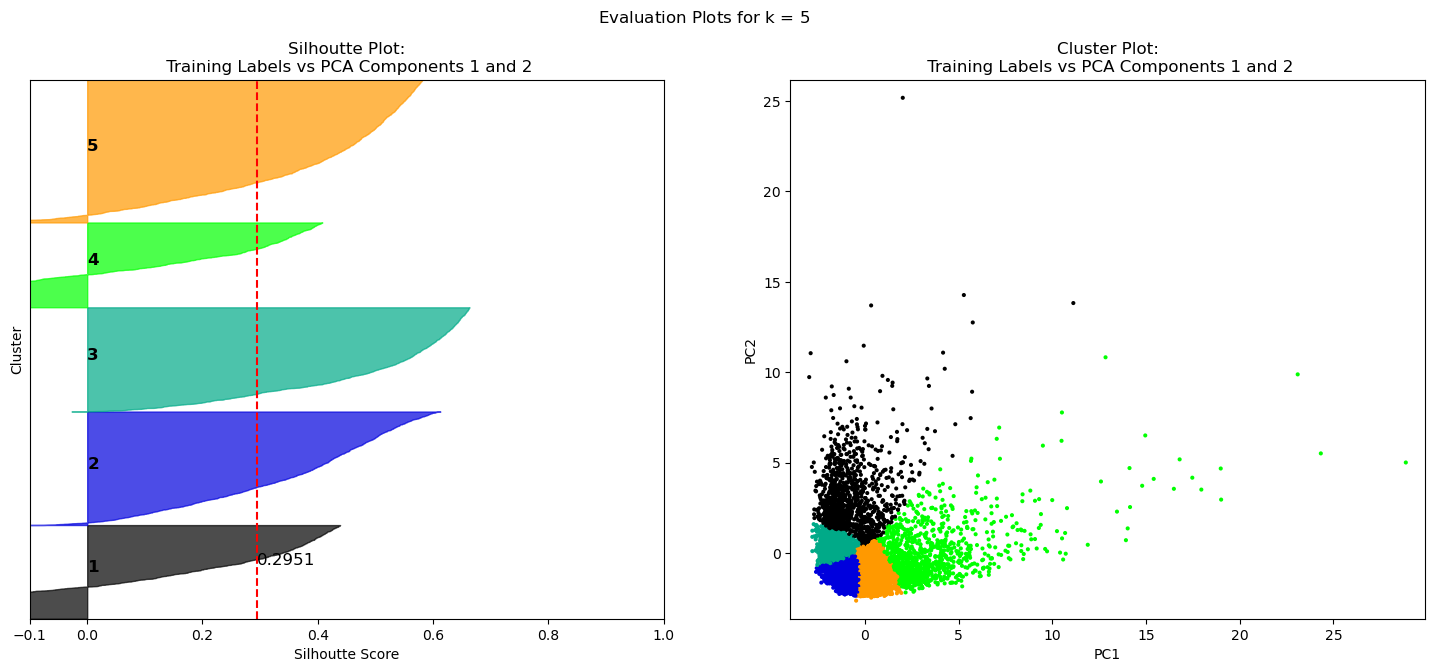

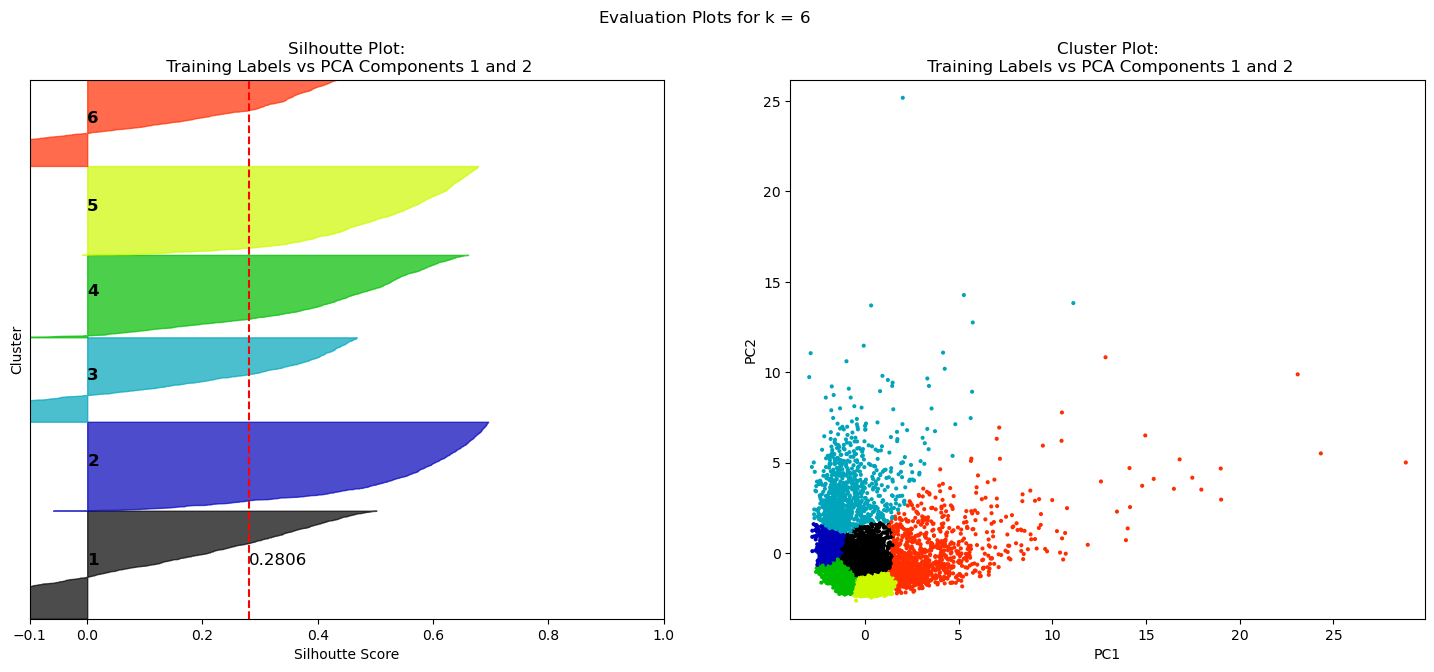

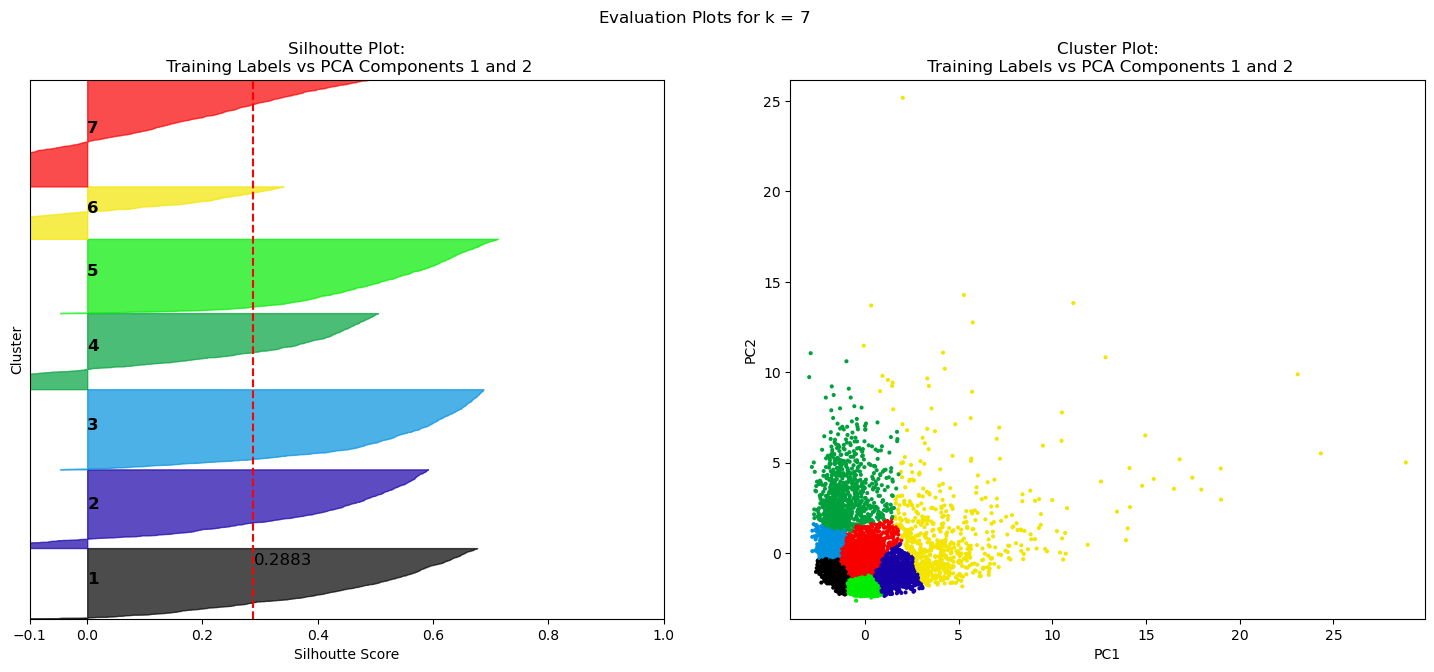

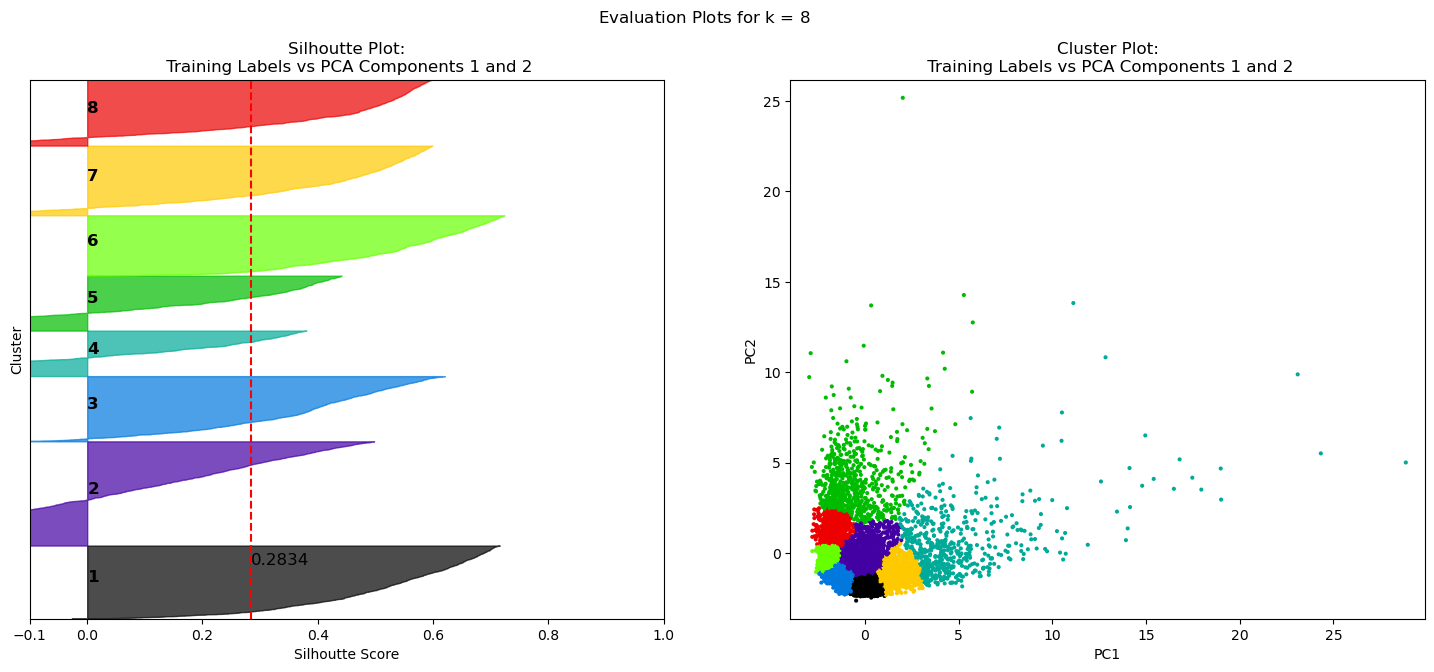

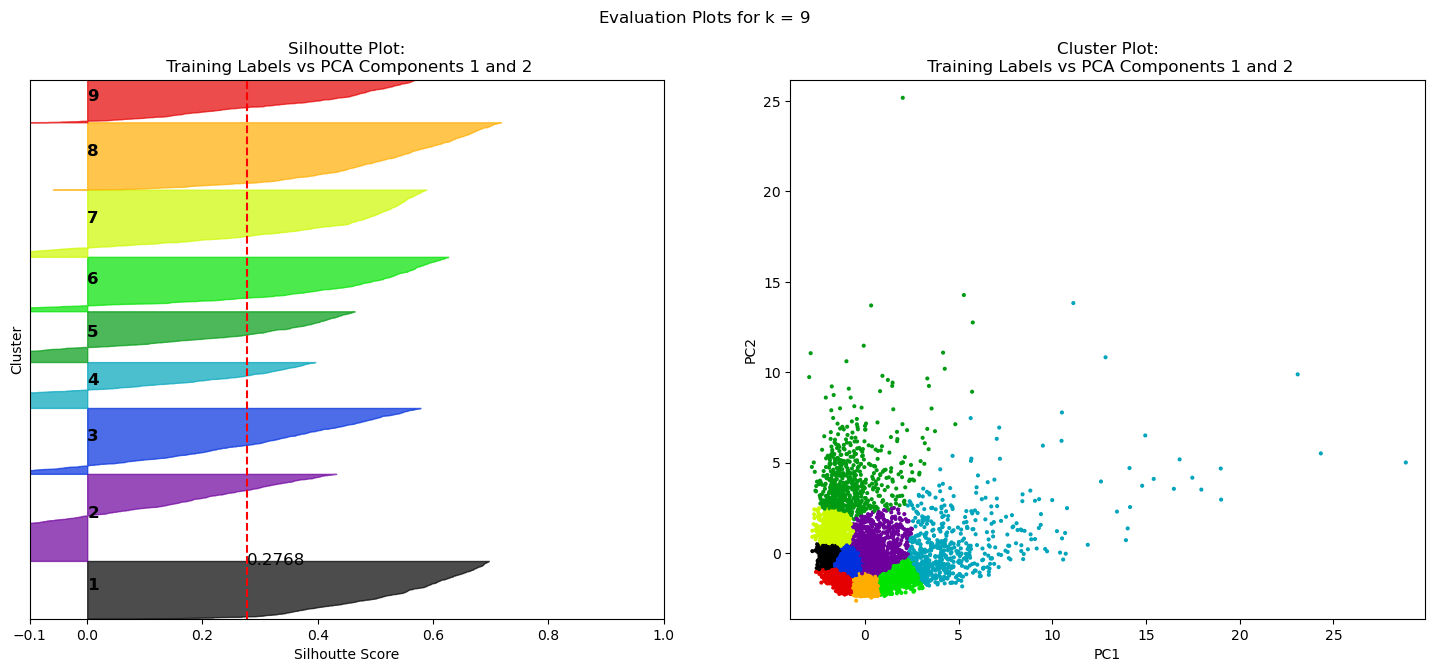

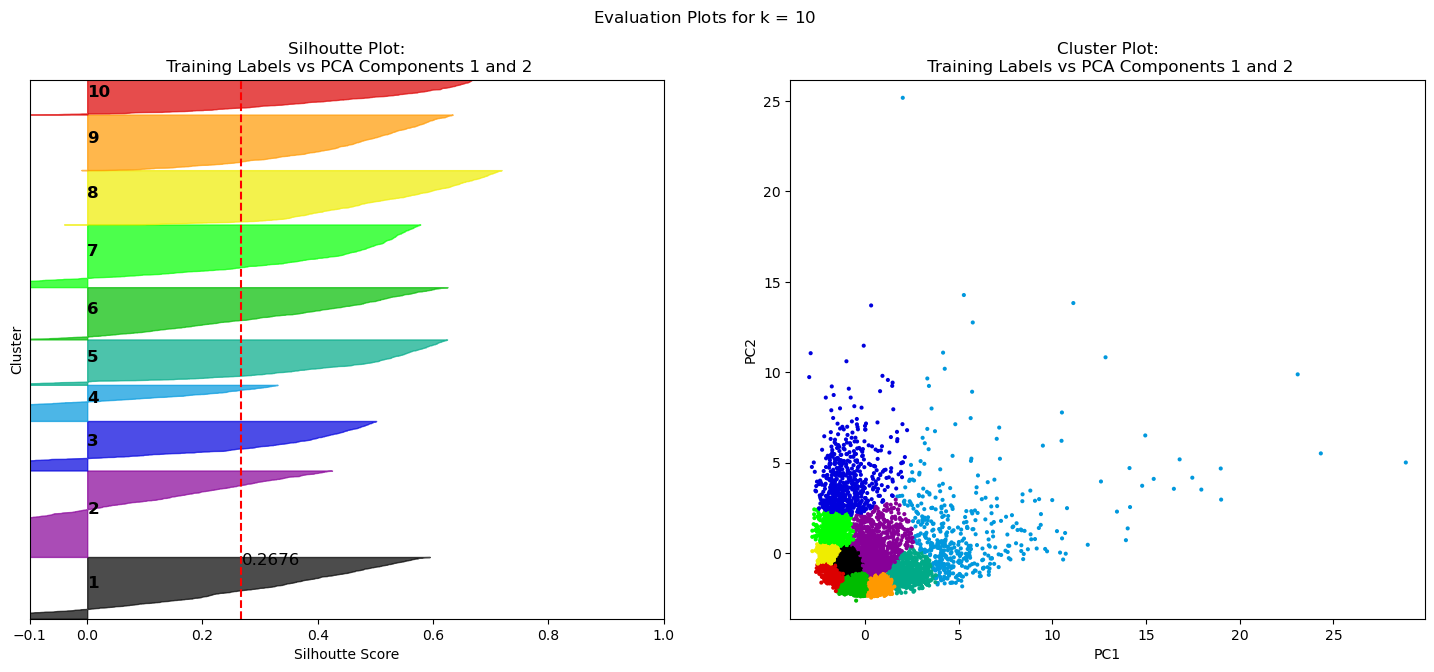

In [144]:
# explore various number of clusters, k to select optimal
# k_values = [4, 5, 6, 7, 8, 9]
k_values = np.arange(2, 10 + 1, 1)
affinity = 'nearest_neighbors'
# affinity = 'rbf'
jra_plot_clusters(X = X, k_values = k_values, affinity = affinity)

In [ ]:
# show optimal k
myfit = SpectralClustering(n_clusters = 2, affinity = affinity, random_state = random_state)